In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.losses import *
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.regularizers import l1_l2
from tensorflow.python.client import device_lib
import numpy as np

from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import itertools 

print(tf.__version__)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s\n\n' % policy.variable_dtype)

for info in device_lib.list_local_devices():
    if (info.name.find('GPU') != -1):
        print(info)

2.4.1
Compute dtype: float16
Variable dtype: float32


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15685569792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12627908011172071518
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"



In [2]:
def getPath(data_type):
    root = r'../input/shanghaitech-with-people-density-map/ShanghaiTech'
    print(root)
    if data_type.find('part_A')!=-1:
        target_train = os.path.join(root,r'part_A/train_data','images')
        target_test = os.path.join(root,r'part_A/test_data','images')

    elif data_type.find('part_B')!=-1:
        target_train = os.path.join(root,r'part_B/train_data','images')
        target_test = os.path.join(root,r'part_B/test_data','images')

    train_path = []
    for img_path in glob.glob(os.path.join(target_train, '*.jpg')):
        train_path.append(str(img_path))
        
    test_path = []
    for img_path in glob.glob(os.path.join(target_test, '*.jpg')):
        test_path.append(str(img_path))
        
    return train_path, test_path

def load_density(file_path):
    gt_file = h5py.File(file_path, 'r')
    groundtruth = np.asarray(gt_file['density'])
    groundtruth = np.expand_dims(groundtruth, axis=-1)
    return groundtruth

# Get input image path
train_paths, test_paths = getPath('part_B')
# Get ground truth path
gth_train = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in train_paths]
gth_test = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in test_paths]

print('train len:', len(train_paths))
print('test len:', len(test_paths))

print(train_paths[0])
print(gth_train[0])




../input/shanghaitech-with-people-density-map/ShanghaiTech
train len: 400
test len: 316
../input/shanghaitech-with-people-density-map/ShanghaiTech/part_B/train_data/images/IMG_160.jpg
../input/shanghaitech-with-people-density-map/ShanghaiTech/part_B/train_data/ground-truth-h5/IMG_160.h5


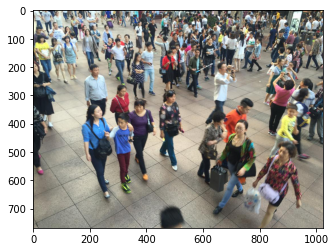

In [3]:
plt.imshow(Image.open(train_paths[0]))

In [4]:
train_labels=np.array([load_density(path) for path in gth_train]).astype('float16')
print(train_labels.shape)
test_labels=np.array([load_density(path) for path in gth_test]).astype('float16')
print(test_labels.shape)

(400, 768, 1024, 1)
(316, 768, 1024, 1)


In [5]:
target_type=tf.dtypes.float16
def load_img(path):
    image_string=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image_string,channels=3)
    image=tf.image.convert_image_dtype(image, target_type)
    return image

def gen_translate_func(translate_range):
    def translate_function(img, gth):
        ratio=tf.random.uniform((2,), minval=translate_range[1], maxval=translate_range[0], dtype=tf.dtypes.int32)
        ratio=tf.cast(ratio, target_type)

        out_gth=tfa.image.translate(gth, ratio, 'BILINEAR')
        out_img=tfa.image.translate(img, ratio, 'BILINEAR')

        return out_img, out_gth
    return translate_function

def gen_downsampling_func(downsampling, method='nearest', batch=True):
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _downsampling_function_(img, gth):
        down_ratio=downsampling
        before_resize=tf.reduce_sum(gth)
        gth_shape=tf.shape(gth)
        out_gth=tf.image.resize(gth, (gth_shape[0+batchadd]//down_ratio, gth_shape[1+batchadd]//down_ratio), method=method,antialias=False)
        out_gth=tf.cast(out_gth, dtype=target_type)
        after_resize=tf.reduce_sum(out_gth)
        if (before_resize >= 0.3) and (after_resize > 0.01):
            out_gth=out_gth * before_resize / after_resize
        return img, out_gth
    return _downsampling_function_

def gen_randomcrop_func(crop_size, batch=True):
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _random_crop_(img, gth):
        
        output_shape=tf.constant(crop_size)
        img_shape=tf.shape(img)

        ratio_x=tf.random.uniform((1,), minval=0, maxval=img_shape[1+batchadd]-output_shape[1], dtype=tf.dtypes.int32)[0]
        ratio_y=tf.random.uniform((1,), minval=0, maxval=img_shape[0+batchadd]-output_shape[0], dtype=tf.dtypes.int32)[0]

        out_img=tf.image.crop_to_bounding_box(img, ratio_y, ratio_x, output_shape[0], output_shape[1])
        out_gth=tf.image.crop_to_bounding_box(gth, ratio_y, ratio_x, output_shape[0], output_shape[1])

        return out_img, out_gth
    return _random_crop_

def gen_coarsedrop_func(hole_count, hole_size, hole_prob=0.75):
    def _dropout_(image, gth):
        shape = tf.shape(image)
        BATCH = shape[0]
        IMG_WIDTH = shape[2]
        IMG_HEIGHT = shape[1]
        IMG_WIDTH_F = tf.cast(IMG_WIDTH, tf.float32)
        IMG_HEIGHT_F = tf.cast(IMG_HEIGHT, tf.float32)
        PROBABILITY = hole_prob
        CT = hole_count
        CROP_SIZE = tf.cast(hole_size,tf.int32)
        # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([], 0.0, 1.0) < PROBABILITY, tf.int32)
        if (P==0): return image, gth
        
        mask = tf.ones((IMG_HEIGHT,IMG_WIDTH,1))
        for k in range(CT):
            # CHOOSE RANDOM LOCATION
            x = tf.cast( tf.random.uniform([],0.0,IMG_WIDTH_F),tf.int32)
            y = tf.cast( tf.random.uniform([],0.0,IMG_HEIGHT_F),tf.int32)
            # COMPUTE SQUARE
            ya = tf.math.maximum(0,y-CROP_SIZE//2)
            yb = tf.math.minimum(IMG_HEIGHT,y+CROP_SIZE//2)
            xa = tf.math.maximum(0,x-CROP_SIZE//2)
            xb = tf.math.minimum(IMG_WIDTH,x+CROP_SIZE//2)
            # DROPOUT IMAGE
            one = mask[ya:yb,0:xa,:]
            two = tf.zeros([yb-ya,xb-xa,1]) 
            three = mask[ya:yb,xb:IMG_WIDTH,:]
            middle = tf.concat([one,two,three],axis=1)
            mask = tf.concat([mask[0:ya,:,:],middle,mask[yb:IMG_HEIGHT,:,:]],axis=0)
        
        # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
        mask = tf.cast(mask, dtype='float16')
        return image*mask, gth*mask
    return _dropout_

def basic_dataset(img_data, label_data, batch_size=1, flip=False, downsampling=1, buffer_size=32, shuffle=False):
    input_data=tf.data.Dataset.from_tensor_slices(img_data)
    input_data = input_data.map(load_img)
    output_data=tf.data.Dataset.from_tensor_slices(label_data)

    if flip:
        input_data=input_data.concatenate(input_data.map(tf.image.flip_left_right))
        output_data=output_data.concatenate(output_data.map(tf.image.flip_left_right))

    dataset=tf.data.Dataset.zip((input_data, output_data))
    if shuffle:
        dataset = dataset.batch(batch_size).repeat().shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    else:
        dataset = dataset.batch(batch_size).repeat()

    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling))
    return dataset

def crop_dataset(img_data, label_data, crop_size, flip, downsampling, batch_size=1, sample_method='bicubic', buffer_size=16, 
hole_count=0, hole_size=100, hole_prob=0.75):
    dataset = basic_dataset(img_data, label_data, flip=flip, batch_size=batch_size, downsampling=1, shuffle=True, buffer_size=buffer_size)
    dataset=dataset.map(gen_randomcrop_func(crop_size))
    if hole_count!=0:
        dataset=dataset.map(gen_coarsedrop_func(hole_count=hole_count, hole_size=hole_size, hole_prob=hole_prob))
    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling, method=sample_method))
    return dataset

def translate_dataset(img_data, label_data, translate_range, flip, downsampling, batch_size=1, sample_method='bicubic', buffer_size=16, 
hole_count=0, hole_size=100, hole_prob=0.75):
    dataset = basic_dataset(img_data, label_data, flip=flip, batch_size=batch_size, downsampling=1, shuffle=True, buffer_size=buffer_size)
    dataset=dataset.map(gen_translate_func(translate_range))
    if hole_count!=0:
        dataset=dataset.map(gen_coarsedrop_func(hole_count=hole_count, hole_size=hole_size, hole_prob=hole_prob))
    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling, method=sample_method))
    return dataset
            
def show_images(images, cols = 2, titles = None, padding=1, axis="off", channel1=CM.jet):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    # if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    if titles is None: titles = [None for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)

        plt.axis(axis)
        plt.subplots_adjust(wspace=padding, hspace=padding)

        if (image.shape[2] == 1):
            image = image[:,:,0]
            plt.imshow(image, cmap=channel1)
        elif np.any(image > 1.0):
            plt.imshow(image / 255.0)
        else:
            plt.imshow(image)
        a.set_title(title, fontsize=20)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
def density_mae(y_truth, y_pred):
    return tf.reduce_mean(tf.abs(tf.reduce_sum(y_truth, axis=(1,2,3))-tf.reduce_sum(y_pred, axis=(1,2,3))))

In [6]:
def CSRNet(batch_norm=False, middle_activation='relu', final_activation='sigmoid', reg=(0.0,0.0), normal_input=True, dilations=[2,2,2,2,2,2], dtype=tf.dtypes.float16):
    init=RandomNormal(stddev=0.01)
    
    activationDict = {
        'sigmoid': tf.math.sigmoid,
        'relu': tf.nn.relu,
        'tanh': tf.math.tanh,
        'leakyrelu': tf.nn.leaky_relu,
        'elu': tf.nn.elu,
        'softsign':tf.nn.softsign
    }
    vgg16 = VGG16(weights='imagenet', include_top=False)
    vgg16.trainable=False
    
    input_layer = Input(shape=(None, None, 3))
    x = input_layer
    if (normal_input):
        x = Lambda(lambda batch: (batch - tf.constant([0.485,0.456,0.406], dtype=dtype)) / tf.constant([0.229,0.224,0.225],dtype=dtype))(x)

    count = 0
    for layer in vgg16.layers:
        layer.trainable = False
        x = layer(x)
        if 'conv' in layer.name:
            count+=1
        if count == 10:
            break;
            
    
    if batch_norm:
        x = BatchNormalization()(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[0], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[0], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[1], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[1], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    if batch_norm:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[2], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=dilations[2], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    
    if batch_norm:
        x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=dilations[3], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=dilations[3], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    
    if batch_norm:
        x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=dilations[4], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=dilations[4], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
    
    
    if batch_norm:
        x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=dilations[5], padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=dilations[5], padding='same', use_bias=True, kernel_initializer=init, kernel_regularizer=l1_l2(l1=reg[0], l2=reg[1]))(x)
    x = Activation(activationDict[middle_activation])(x)
        
    ###############################    
    x = Conv2D(filters=1, kernel_size=(1, 1), dilation_rate=1, padding='same', use_bias=True, kernel_initializer=init)(x)
    x = Activation(activationDict[final_activation])(x)
    
    model = Model(input_layer, x)
    return model

In [7]:
sgd = SGD(lr = 1e-4, momentum = 0.7, nesterov=True)
rms = RMSprop(lr=1e-4, momentum=0.7, decay=0.0001)
nadam = Nadam(lr=1e-2)

optimizer = rms
loss = 'binary_crossentropy'

batch_size=8
train_size=320

val_gen = basic_dataset(train_paths[train_size:], train_labels[train_size:], batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
test_gen = basic_dataset(test_paths, test_labels, batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
train_gen  = crop_dataset(train_paths[:train_size], train_labels[:train_size], crop_size=(760,1000), flip=True, downsampling=8, batch_size=batch_size, sample_method='bicubic', buffer_size=8)

filepath = r'/kaggle/working/CSRNet_1'
reduceLR=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_density_mae', factor=0.5, patience=5, verbose=1, min_delta=1e-8)
earlyStop=tf.keras.callbacks.EarlyStopping(monitor='val_density_mae', patience=25, verbose=1, restore_best_weights=True)
monitor=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_density_mae', verbose=0, save_best_only=True, save_weights_only=True)


model = CSRNet(middle_activation='relu', final_activation='sigmoid', dtype=tf.dtypes.float16)
model.compile(optimizer=optimizer, loss=loss, metrics=[density_mae])
model.build(input_shape=(None, None, None, 3))

print('train baseline: ', np.mean( np.sum(train_labels[:train_size], axis=(1,2,3))))
print('val baseline: ', np.mean( np.sum(train_labels[320:], axis=(1,2,3))))

model.fit(train_gen, steps_per_epoch=int(train_size*2/batch_size), epochs=80, verbose=1, use_multiprocessing=True,
              max_queue_size=32, workers=6, validation_data=val_gen, validation_steps=80, callbacks=[earlyStop, monitor, reduceLR])

model.load_weights(filepath)
model.evaluate(val_gen, steps=80, verbose=1, workers=4)
model.evaluate(test_gen, steps=316, verbose=1, workers=4)

58892288/58889256 [==============================] - 1s 0us/step
train baseline:  118.1
val baseline:  122.3
Epoch 1/80
80/80 [==============================] - 93s 1s/step - loss: 0.2731 - density_mae: 1984.7881 - val_loss: 0.0425 - val_density_mae: 29.3167
Epoch 2/80
80/80 [==============================] - 79s 985ms/step - loss: 0.0413 - density_mae: 31.3187 - val_loss: 0.0401 - val_density_mae: 26.8536
Epoch 3/80
80/80 [==============================] - 78s 982ms/step - loss: 0.0383 - density_mae: 22.1574 - val_loss: 0.0391 - val_density_mae: 26.3328
Epoch 4/80
80/80 [==============================] - 79s 984ms/step - loss: 0.0385 - density_mae: 22.5480 - val_loss: 0.0386 - val_density_mae: 24.8691
Epoch 5/80
80/80 [==============================] - 80s 996ms/step - loss: 0.0370 - density_mae: 19.6135 - val_loss: 0.0381 - val_density_mae: 21.0253
Epoch 6/80
80/80 [==============================] - 79s 988ms/step - loss: 0.0376 - density_mae: 19.6581 - val_loss: 0.0378 - val_density

[0.036006998270750046, 12.687824249267578]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


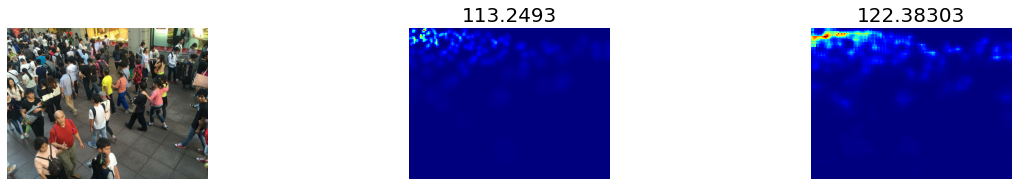

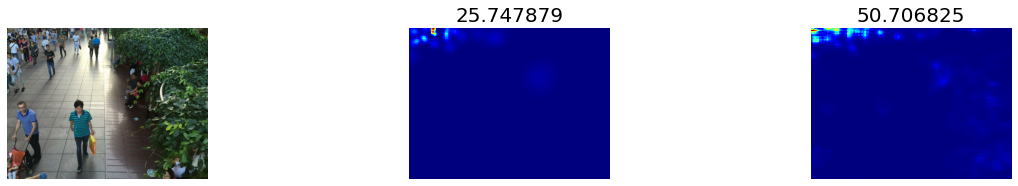

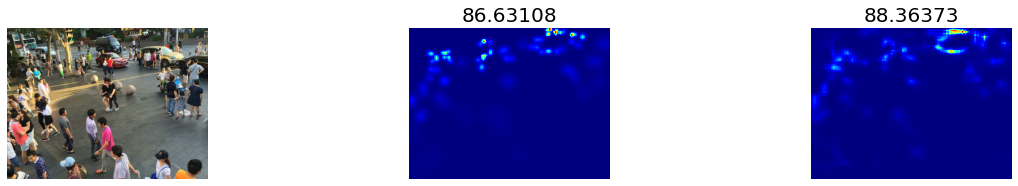

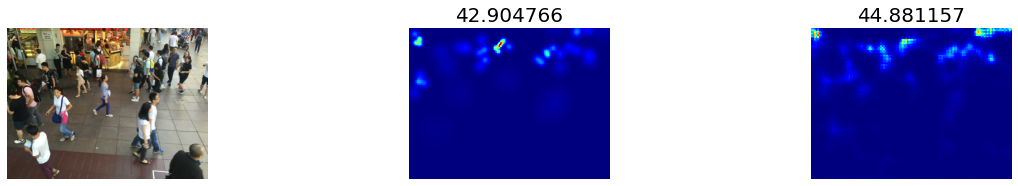

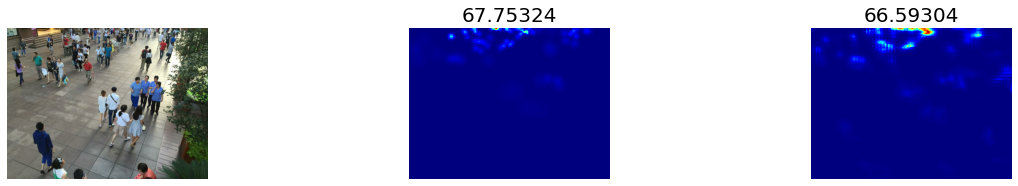

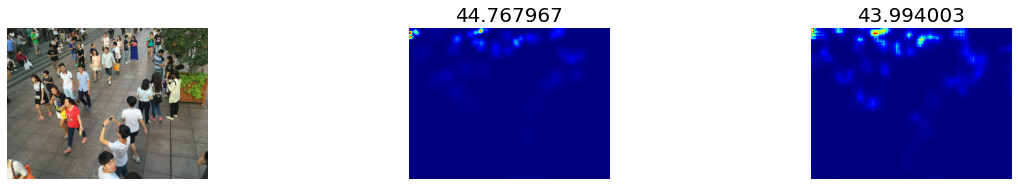

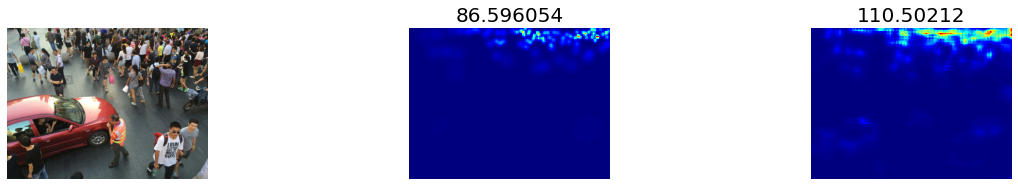

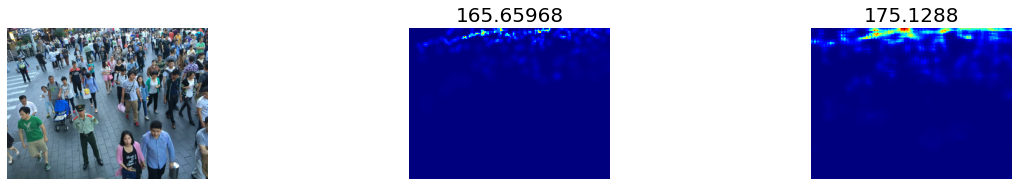

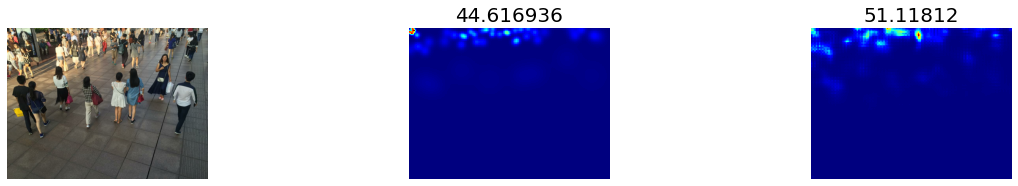

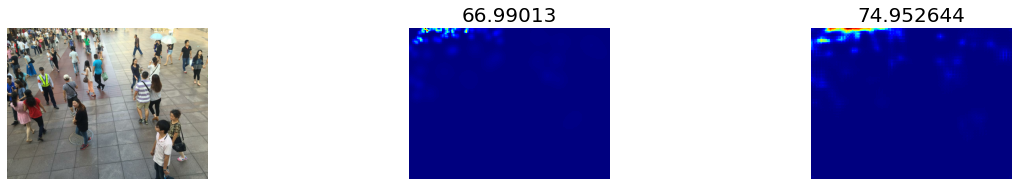

In [27]:
for a,b in test_gen.take(10):
    c = model.predict(a)
    a = tf.cast(a, dtype=tf.dtypes.float32)
    b = tf.cast(b, dtype=tf.dtypes.float32)
    c = c.astype('float32')
    show_images([a[0], b[0], c[0]], 1, ['', np.sum(b[0]), np.sum(c[0])])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


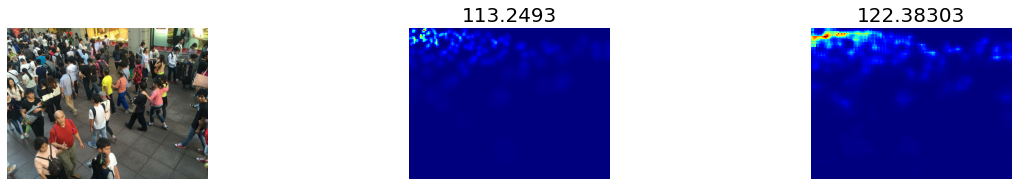

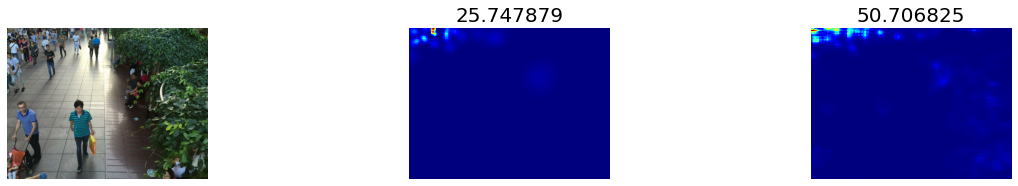

In [31]:
for a,b in test_gen.take(2):
    c = model.predict(a)
    a = tf.cast(a, dtype=tf.dtypes.float32)
    b = tf.cast(b, dtype=tf.dtypes.float32)
    c = c.astype('float32')
    show_images([a[0], b[0], c[0]], 1, ['', np.sum(b[0]), np.sum(c[0])])